In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

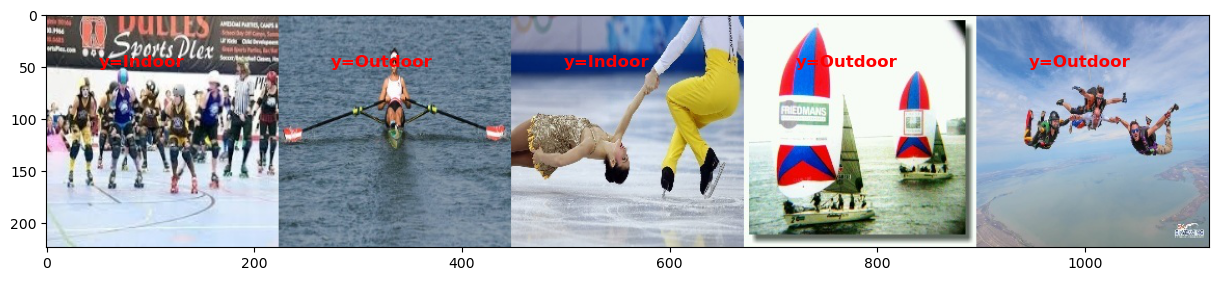

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dir = "/projects/dsci410_510/Final_proj_ms/train"
valid_dir = "/projects/dsci410_510/Final_proj_ms/valid"
test_dir = "/projects/dsci410_510/Final_proj_ms/test"

train_data = datasets.ImageFolder(root=train_dir, transform=transform)
valid_data = datasets.ImageFolder(root=valid_dir, transform=transform)
test_data = datasets.ImageFolder(root=test_dir, transform=transform)

indoor_sports = {
    'air hockey', 'arm wrestling', 'axe throwing', 'balance beam', 'billiards', 'bowling', 
    'boxing', 'cheerleading', 'curling', 'fencing', 'figure skating men', 'figure skating women',
    'figure skating pairs', 'parallel bar', 'pommel horse', 'uneven bars', 'rings', 'judo',
    'roller derby', 'shuffleboard', 'sumo wrestling', 'table tennis', 'trapeze', 'weightlifting', 
    'wheelchair basketball'
}

def indoor_outdoor_label(class_name):
    return 0 if class_name in indoor_sports else 1

class IndoorOutdoorDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.label_map = {idx: indoor_outdoor_label(class_name) for idx, class_name in enumerate(dataset.classes)}
        self.classes = ["Indoor", "Outdoor"]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, original_label = self.dataset[idx]
        new_label = self.label_map[original_label]
        return image, new_label

train_data = IndoorOutdoorDataset(train_data)
valid_data = IndoorOutdoorDataset(valid_data)
test_data = IndoorOutdoorDataset(test_data)

train_loader = DataLoader(train_data, batch_size=5, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=5, shuffle=False)
test_loader = DataLoader(test_data, batch_size=5, shuffle=False)

images, labels = next(iter(train_loader))

mean = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1)
std = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1)
plot_images = images * std + mean
plot_images = (plot_images * 255.0).numpy().astype(np.uint8).transpose(0, 2, 3, 1)

plt.figure(figsize=(15, 5))
plt.imshow(np.hstack(plot_images))

for index, label in enumerate(labels):
    plt.text(index * 224 + 50, 50, f"y={train_data.classes[label.item()]}", color='red', fontsize=12, fontweight='bold')

plt.savefig('./train_batch.png')
plt.show()

Epoch [1/10], Train Loss: 0.4692, Train Acc: 78.64%, Valid Loss: 0.4257, Valid Acc: 79.20%
Epoch [2/10], Train Loss: 0.4256, Train Acc: 81.00%, Valid Loss: 0.3984, Valid Acc: 79.80%
Epoch [3/10], Train Loss: 0.3524, Train Acc: 84.92%, Valid Loss: 0.3558, Valid Acc: 84.80%
Epoch [4/10], Train Loss: 0.2616, Train Acc: 89.38%, Valid Loss: 0.5081, Valid Acc: 84.20%
Epoch [5/10], Train Loss: 0.1557, Train Acc: 94.20%, Valid Loss: 0.5929, Valid Acc: 84.80%
Epoch [6/10], Train Loss: 0.0853, Train Acc: 96.90%, Valid Loss: 0.6017, Valid Acc: 83.80%
Epoch [7/10], Train Loss: 0.0530, Train Acc: 98.30%, Valid Loss: 0.8172, Valid Acc: 85.40%
Epoch [8/10], Train Loss: 0.0443, Train Acc: 98.69%, Valid Loss: 1.1107, Valid Acc: 84.80%
Epoch [9/10], Train Loss: 0.0349, Train Acc: 98.97%, Valid Loss: 1.3094, Valid Acc: 84.00%
Epoch [10/10], Train Loss: 0.0354, Train Acc: 99.21%, Valid Loss: 1.1485, Valid Acc: 83.00%


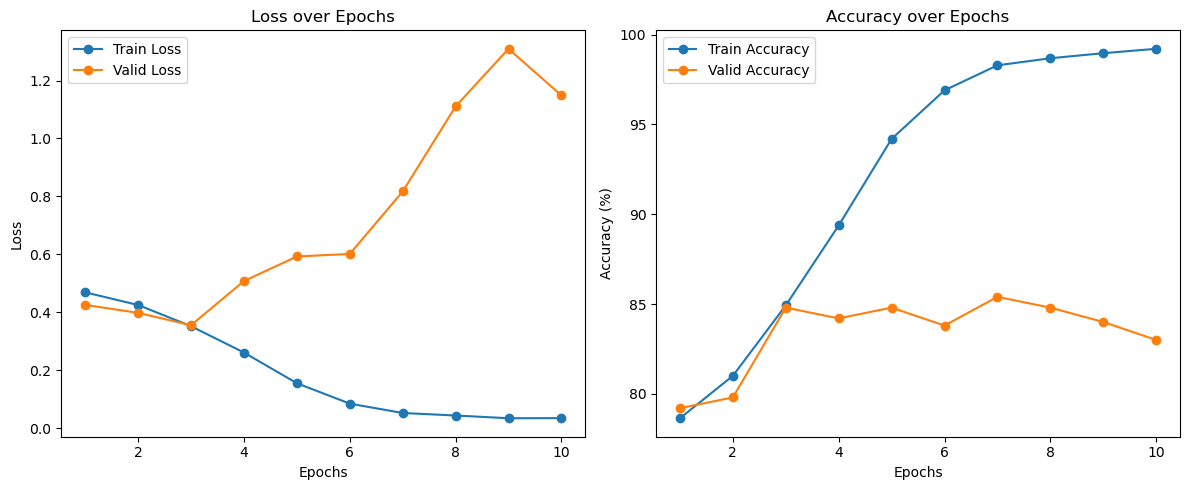

In [8]:
import torch.nn as nn
import torch.optim as optim

# Define the CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 2)  # Output: 2 classes (Indoor or Outdoor)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2(x)))
        x = self.relu(self.pool(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = CNNModel().to('cuda' if torch.cuda.is_available() else 'cpu')

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function with loss and accuracy tracking
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        # Validation phase
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to('cuda'), labels.to('cuda')
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        valid_losses.append(valid_loss / len(valid_loader))
        valid_accuracies.append(100 * correct / total)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Valid Loss: {valid_losses[-1]:.4f}, Valid Acc: {valid_accuracies[-1]:.2f}%')

    return train_losses, train_accuracies, valid_losses, valid_accuracies

# Train and store results
train_losses, train_accuracies, valid_losses, valid_accuracies = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10)

# Plot Loss and Accuracy Curves
epochs = range(1, 11)
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, valid_accuracies, label='Valid Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.savefig('./training_plot.png')
plt.show()